# Training a deep (convolutional) neural network on CIFAR10

In [16]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

print(tf.__version__)
print(tf.config.list_physical_devices())



2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Code Convolutions

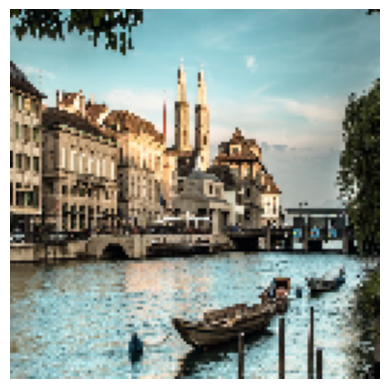

In [3]:
img =  tf.keras.utils.load_img('test1.png', target_size=(128,128))
data =  tf.keras.utils.img_to_array(img)/255.0
samples = tf.expand_dims(data, 0)


plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

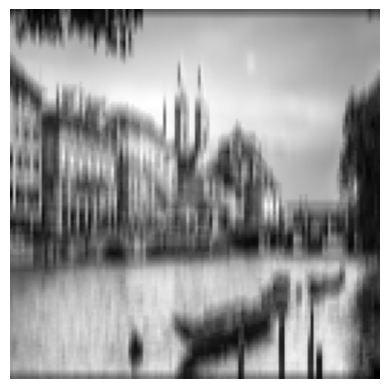

In [ ]:
# Bild laden, 128x128 skalieren, in npArray umwandeln und normalisieren
img =  tf.keras.utils.load_img('test1.png', target_size=(128,128))
data =  tf.keras.utils.img_to_array(img)/255.0
samples = tf.expand_dims(data, 0) # Batchdimension hinzufügen (Anzahl Bilder) an Stelle 0 -> nun also (1, 128, 128, 3)

channels = 3


# Hier wird leerer Filter mit Nullen erstellt. 7x7 Pixel gross, 3 Kanäle und 1 Filter
# ATTENTION: Convolutions in keras are 4D, meaning [num_pixels, num_pixels, num_channels, num_filters]
#define the structure of the filter
filter = np.zeros(shape=(7, 7, channels, 1), dtype=np.float32)

#assign the right numerical values to the array (filters weights)
# Vertical -> : bedeutet gesamte Höhe | 3 bedeutet Spalte 3 also die mittlere, : : bedeutet alle 3 Farbkanäle und der eine vorhandene Filter
# Es wird also ein Filter gebaut bei dem in allen Zeilen in der mittleren Spalte 1 und sonst wie beim oben definierten Filter 0 bleibt. Zeile also 0001000
filter[:, 3, :, :] = 1  # vertical line
#filter[3, :, :, :] = 1  # horizontal line

#conv2d(...) ist die Funktion, die die Faltung (Convolution) durchführt
#Strides = filter wird Pixel für Pixel verschoben
#Padding Same = Ergebnis hat gleiche grösse wie Eingabebild (trotz verschiebung)
outputs = tf.nn.conv2d(samples, filter, strides=1, padding="SAME")


#Erste Feature Map des ausgegebenen Bildes zeigen
#[0,:,:,0] = Erstes Bild im Batch, alle Zeilen/Spalten, Erste und einzige Filterausgabe
plt.imshow(outputs[0, :, :, 0], cmap="gray")
plt.axis("off")
plt.show()

## Ex2: CNN on CIFAR 10

In [5]:
#setup folder where you will save logs for tensorflow
root_logdir = os.path.join(os.curdir,"my_logs_ML2_CIFAR")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)



Import the CIFAR 10 library, split into train, validation and test images.

In [6]:
cifar = tf.keras.datasets.cifar10

(train_full_images, train_full_labels), (test_images, test_labels) = cifar.load_data()

valid_images, train_images = train_full_images[:5000], train_full_images[5000:]
valid_labels, train_labels = train_full_labels[:5000], train_full_labels[5000:]
test_images = test_images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


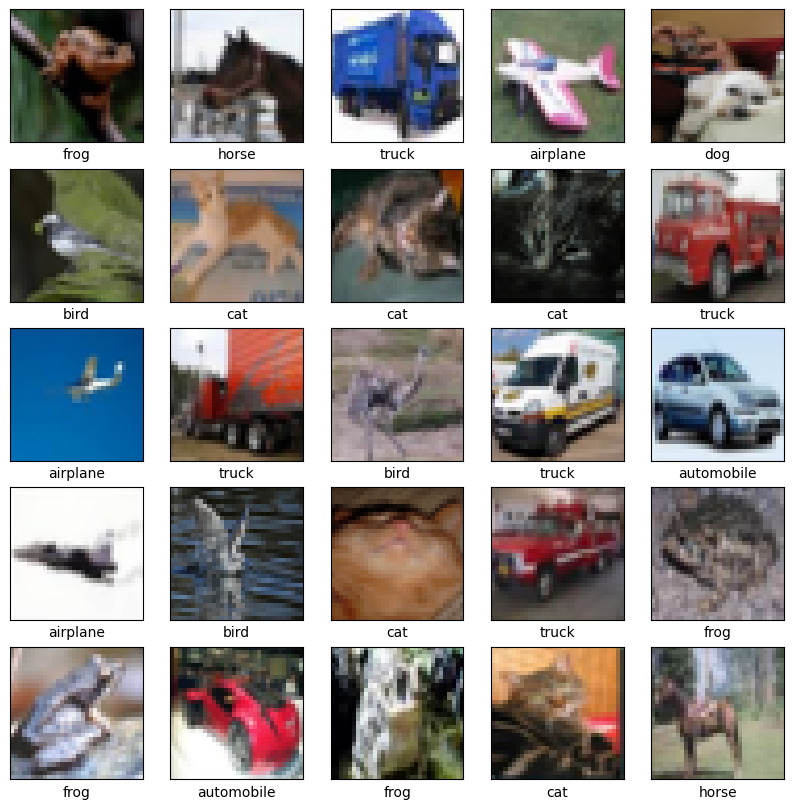

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Check out some properties of the imported dataset

In [8]:
print('training ds shape:', train_images.shape)
print('validation ds shape:', valid_images.shape)
print('test ds shape:', test_images.shape)

training ds shape: (45000, 32, 32, 3)
validation ds shape: (5000, 32, 32, 3)
test ds shape: (10000, 32, 32, 3)


In [9]:
print("labels: ", train_labels)

labels:  [[6]
 [7]
 [9]
 ...
 [9]
 [1]
 [1]]


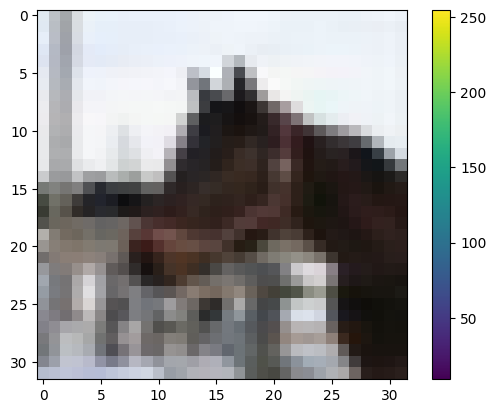

In [10]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

Normalization of data between 0 and 1

In [11]:
train_images = train_images / 255.0

valid_images = valid_images / 255.0

test_images = test_images / 255.0

In [17]:
run_logdir = get_run_logdir()



#create keras Tensorboard callback and early stopping_callback
tensorboard_cb = TensorBoard(log_dir=run_logdir)
earlystopping_cb = EarlyStopping(
    monitor="val_loss",          # beobachte den Validierungsfehler
    patience=3,                  # warte 3 Epochen ohne Verbesserung
    restore_best_weights=True    # stell das beste Modell wieder her
)

In [ ]:

#Conv2D: Muster (Kanten, Farben etc) erkennen
#Relu filtert alle z Werte unter 0 raus bzw sie werden zu 0, da nicht relevant -> Mit Relu kann Netzwerk nicht lineare Muster erkennen (Kurven, Kreise etc). Es schaltet also die Neuronen ab die darauf spezialisiert sind etwas in diesem Fall nicht relevantes zu erkennen.
#MaxPooling2D: Bildgrösse verkleinern, Details zusammenfassen
#Flatten: Für Dense Schicht vorbereiten (zb 28x28x1 Bild in 784 Zahlen Vektor umwandeln)
#Dense: Entscheidung treffen (jedes Neuron erhält alle Werte des Vektors, gewichtet sie (im Training) und bildet 1 neuen Wert und wendet darauf Aktivierungsfunktion an (128N -> neuer Vektor mit 128 Wert))
#Dropout + L2: Schutz vor Overfitting
#Softmax: Ergebnis als Wahrscheinlichkeiten ausgeben (vorher war Logit oä)
#
#Conv2D: zb 32 Filter die 3x3 Fenster analysieren
#Relu um die Filter die nichts brauchbares gefunden haben auszuschalten & nichtlinearität einzuführen
#Padding Same füllt am Rand des Bildes Nullen ein, um den Filter auch in Ecken anwenden zu können. padding ="valid" wenn gezielt Bildgrösse reduzieren will. Same kann künstliche Kanten am Bildrand erzeugen.
# würde in Ecken filter nicht anwenden und dann zb bei einem 32x32 Bild mit 3x3 Filter nur ein 30x30 Bild zurückgeben
#Input Shape: Bild ist 32x32 mit 3 Kanälen
#
#MaxPooling: 2,2 Reduziert Bildgrösse um Hälfte. Nimmt
#
#


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
])


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.99),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.fit(train_images, train_labels, epochs=20, validation_data=(valid_images, valid_labels), callbacks=[tensorboard_cb, earlystopping_cb])

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.3049 - loss: 1.9994 - val_accuracy: 0.5098 - val_loss: 1.4859
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.4932 - loss: 1.5051 - val_accuracy: 0.5826 - val_loss: 1.3023
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.5560 - loss: 1.3675 - val_accuracy: 0.6170 - val_loss: 1.2037
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.5970 - loss: 1.2645 - val_accuracy: 0.6524 - val_loss: 1.1333
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.6295 - loss: 1.1934 - val_accuracy: 0.6588 - val_loss: 1.1055
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.6464 - loss: 1.1427 - val_accuracy: 0.6876 - val_loss: 1.0384
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.6697 - loss: 1.0859 - val_accuracy: 0.6956 - val_loss: 1.0236
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.6809 -

In [ ]:
%load_ext tensorboard
%tensorboard --logdir my_logs_ML2_CIFAR

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [22]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - 6ms/step - accuracy: 0.7152 - loss: 0.9637

Test accuracy: 0.7152000069618225


In [23]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('blue')

In [24]:
predictions = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


/tmp/ipykernel_17339/1610483472.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_names[int(true_label)]),
/tmp/ipykernel_17339/1610483472.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thisplot[int(true_label)].set_color('blue')


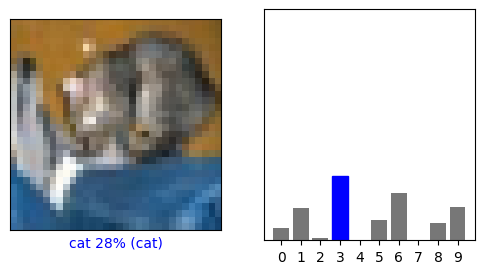

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [26]:
img = tf.keras.utils.load_img("./test_image.jpg", target_size=(32,32)#download your own image
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

FileNotFoundError: [Errno 2] No such file or directory: './test_image.jpg'